In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

import time
from tqdm import tqdm_notebook as tqdm


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv


In [2]:
train = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv")
train.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  
1       1       0       0       0       0  
2       1       0       1       1       1  
3       0       1       3       7       2  
4       1       2       2       2       4  

[5 rows x 1919 columns]

In [3]:
train.shape

(30490, 1919)

In [4]:
calendar = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/calendar.csv")
calendar.head()


date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [5]:
sell_prices = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sell_prices.csv")
sell_prices.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [6]:
series_cols = train.columns[train.columns.str.contains("d_")].values
level_cols = train.columns[train.columns.str.contains("d_")==False].values

In [7]:
train.head(1)

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  

[1 rows x 1919 columns]

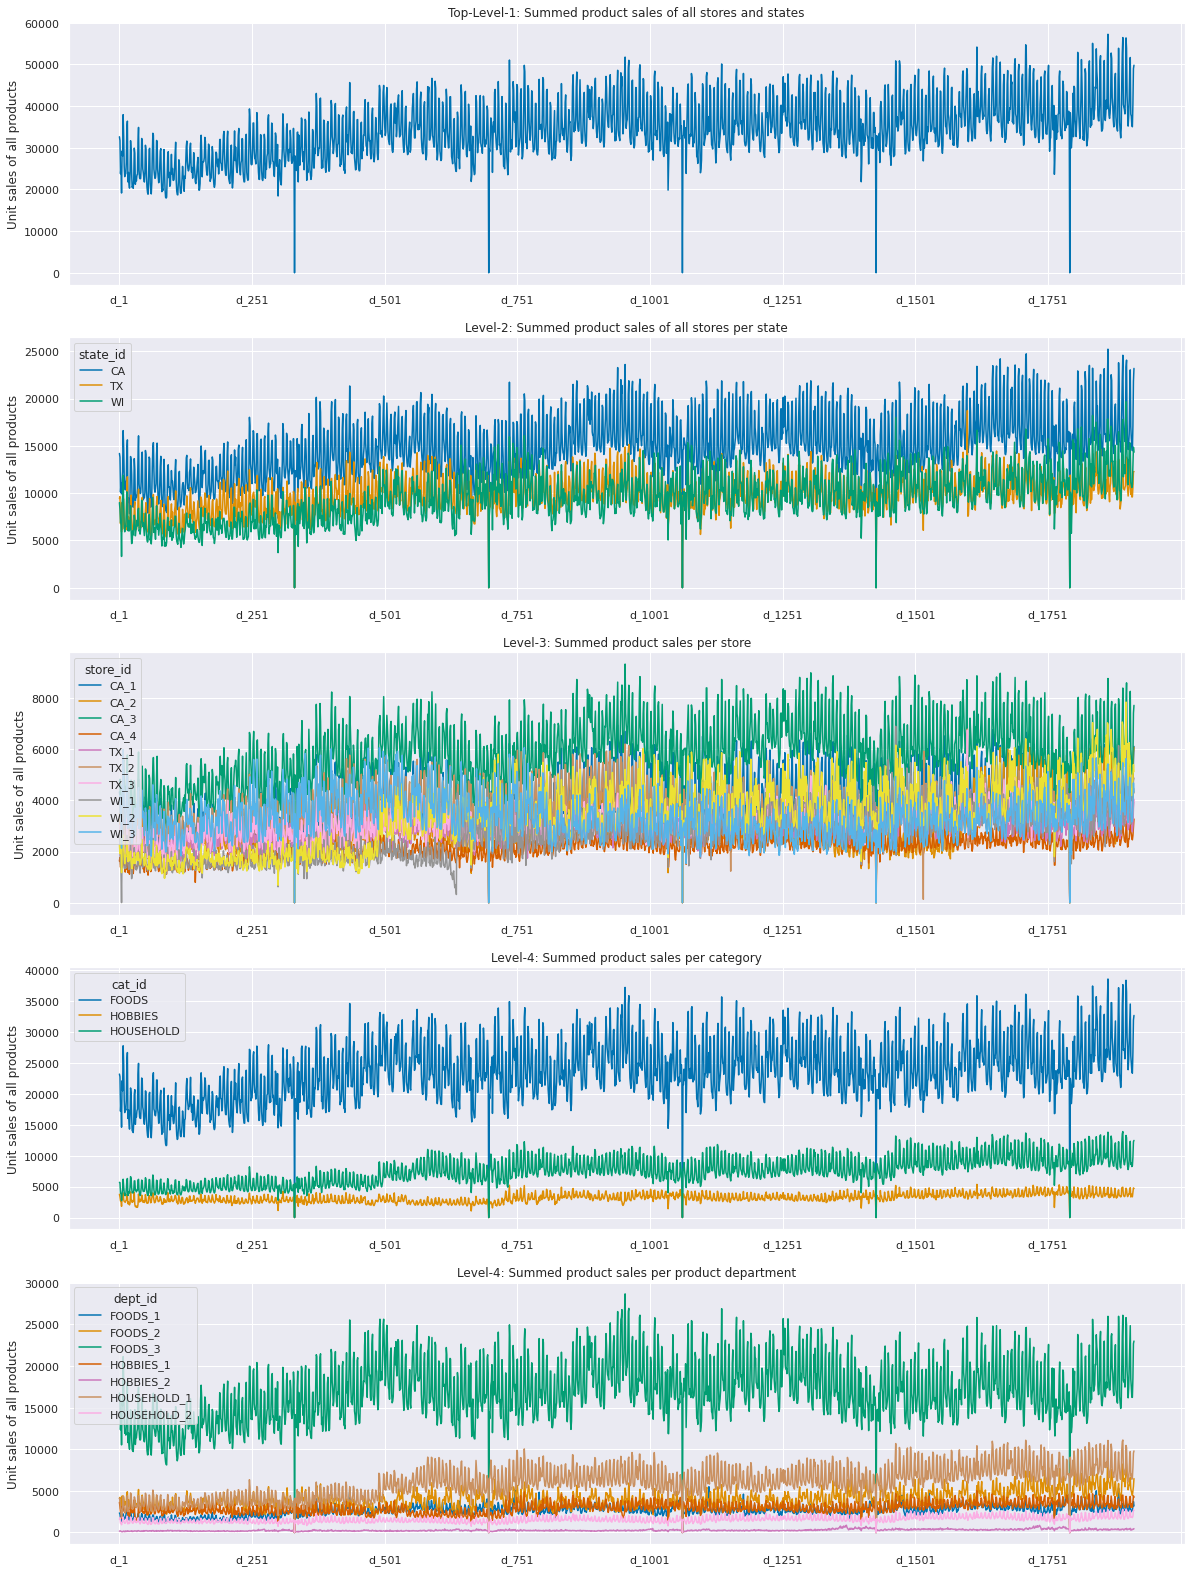

In [8]:
sns.set_palette("colorblind")
fig, ax = plt.subplots(5,1,figsize=(20,28))
train[series_cols].sum().plot(ax=ax[0])
ax[0].set_title("Top-Level-1: Summed product sales of all stores and states")
ax[0].set_ylabel("Unit sales of all products");
train.groupby("state_id")[series_cols].sum().transpose().plot(ax=ax[1])
ax[1].set_title("Level-2: Summed product sales of all stores per state");
ax[1].set_ylabel("Unit sales of all products");
train.groupby("store_id")[series_cols].sum().transpose().plot(ax=ax[2])
ax[2].set_title("Level-3: Summed product sales per store")
ax[2].set_ylabel("Unit sales of all products");
train.groupby("cat_id")[series_cols].sum().transpose().plot(ax=ax[3])
ax[3].set_title("Level-4: Summed product sales per category")
ax[3].set_ylabel("Unit sales of all products");
train.groupby("dept_id")[series_cols].sum().transpose().plot(ax=ax[4])
ax[4].set_title("Level-4: Summed product sales per product department")
ax[4].set_ylabel("Unit sales of all products");

In [9]:
submission = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sample_submission.csv")
submission.head(10)

id  F1  F2  F3  F4  F5  F6  F7  F8  F9  ...  \
0  HOBBIES_1_001_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
1  HOBBIES_1_002_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
2  HOBBIES_1_003_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
3  HOBBIES_1_004_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
4  HOBBIES_1_005_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
5  HOBBIES_1_006_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
6  HOBBIES_1_007_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
7  HOBBIES_1_008_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
8  HOBBIES_1_009_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
9  HOBBIES_1_010_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   

   F19  F20  F21  F22  F23  F24  F25  F26  F27  F28  
0    0    0    0    0    0    0    0    0    0    0  
1    0    0    0    0    0    0    0    0    0    0  
2    0    0    0    0    0    0    0    0    0    0  
3    0    0    0    0    0    0    0    0    0    0  
4    0    0    0    0    0    0    0    0    0    0  
5    0    0    0    0    0    0    0    0    0    0  
6    0    0    0    0    0    0    0    0    0    0  
7    0    0    0    0    0    0    0    0    0    0  
8    0    0    0    0    0    0    0    0    0    0  
9    0    0    0    0    0    0    0    0    0    0  

[10 rows x 29 columns]

In [10]:
submission.shape

(60980, 29)

In [11]:
np.random.choice(submission.id.values, replace=False, size=15)

array(['HOBBIES_1_107_WI_3_validation', 'HOBBIES_1_117_CA_4_validation',
       'FOODS_2_335_WI_3_validation', 'FOODS_3_558_CA_4_validation',
       'HOUSEHOLD_2_268_WI_3_evaluation',
       'HOUSEHOLD_2_404_TX_3_evaluation', 'HOBBIES_1_312_WI_1_evaluation',
       'FOODS_3_648_TX_2_validation', 'HOBBIES_1_148_TX_1_validation',
       'HOBBIES_2_115_CA_2_evaluation', 'FOODS_3_210_CA_2_evaluation',
       'HOBBIES_1_046_WI_3_validation', 'HOBBIES_1_033_WI_3_validation',
       'HOUSEHOLD_2_054_TX_3_validation',
       'HOUSEHOLD_2_274_WI_2_validation'], dtype=object)

In [12]:
def find_quartil(l):
    
    if "0.005" in l:
        return 0.005
    elif "0.025" in l:
        return 0.025
    elif "0.165" in l:
        return 0.165
    elif "0.25" in l:
        return 0.25
    elif "0.5" in l:
        return 0.5
    elif "0.75" in l:
        return 0.75
    elif "0.835" in l:
        return 0.835
    elif "0.975" in l:
        return 0.975
    elif "0.995" in l:
        return 0.995
    else:
        return 0

def find_state(l):
    if "CA" in l:
        return "CA"
    elif "TX" in l:
        return "TX"
    elif "WI" in l:
        return "WI"
    else:
        return "Unknown"

def find_category(l):
    if "FOODS" in l:
        return "foods"
    elif "HOBBIES" in l:
        return "hobbies"
    elif "HOUSEHOLD" in l:
        return "household"
    else:
        return "Unknown"

In [13]:
submission_eda = pd.DataFrame(submission.id, columns=["id"])
submission_eda.loc[:, "lb_type"] = np.where(submission.id.str.contains("validation"), "validation", "evaluation")
submission_eda.loc[:, "u"] = submission.id.apply(lambda l: find_quartil(l))
submission_eda.loc[:, "state"] = submission.id.apply(lambda l: find_state(l))
submission_eda.loc[:, "category"] = submission.id.apply(lambda l: find_category(l))

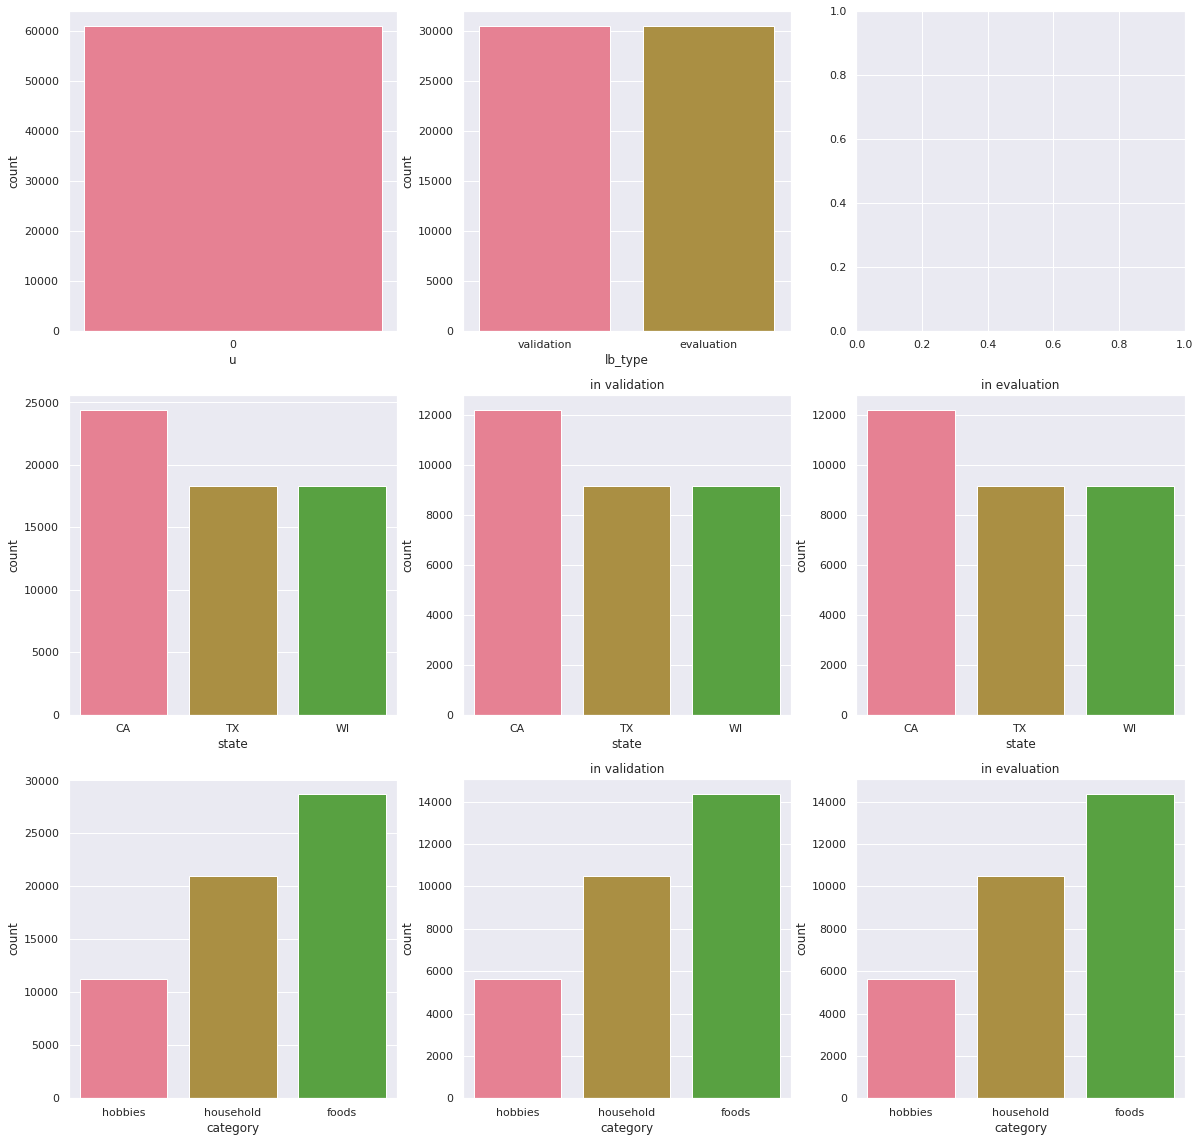

In [14]:
sns.set_palette("husl")

fig, ax = plt.subplots(3,3,figsize=(20,20))
sns.countplot(submission_eda.u, ax=ax[0,0]);
sns.countplot(submission_eda.lb_type, ax=ax[0,1]);
sns.countplot(submission_eda.state, ax=ax[1,0]);
sns.countplot(submission_eda.loc[submission_eda.lb_type=="validation"].state, ax=ax[1,1]);
sns.countplot(submission_eda.loc[submission_eda.lb_type=="evaluation"].state, ax=ax[1,2]);
sns.countplot(submission_eda.category, ax=ax[2,0]);
sns.countplot(submission_eda.loc[submission_eda.lb_type=="validation"].category, ax=ax[2,1]);
sns.countplot(submission_eda.loc[submission_eda.lb_type=="evaluation"].category, ax=ax[2,2]);
for n in range(1,3):
    ax[n,2].set_title("in evaluation")
    ax[n,1].set_title("in validation")

In [15]:
def spl_denominator(train_series):
    N = len(train_series)
    sumup = 0
    for n in range(1, N):
        sumup += np.abs(train_series[n]-train_series[n-1])
    return sumup/(N-1)

In [16]:
def spl_numerator(dev_series, Q, u):
    sumup = 0
    for m in range(len(dev_series)):
        if Q[m] <= dev_series[m]:
            sumup += (dev_series[m] - Q[m])*u
        else:
            sumup += (Q[m] - dev_series[m])*(1-u)
    return sumup

In [17]:
def spl(train_series, dev_series, Q, u):
    h = len(dev_series)
    spl_denomina = spl_denominator(train_series)
    spl_numera = spl_numerator(dev_series, Q, u)
    
    return spl_numera/(h*spl_denomina)

In [18]:
idx = 1000

In [19]:
train[level_cols].iloc[idx]

id          HOUSEHOLD_1_445_CA_1_validation
item_id                     HOUSEHOLD_1_445
dept_id                         HOUSEHOLD_1
cat_id                            HOUSEHOLD
store_id                               CA_1
state_id                                 CA
Name: 1000, dtype: object

In [20]:
train.loc[train.item_id=="HOUSEHOLD_1_445"].store_id.unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

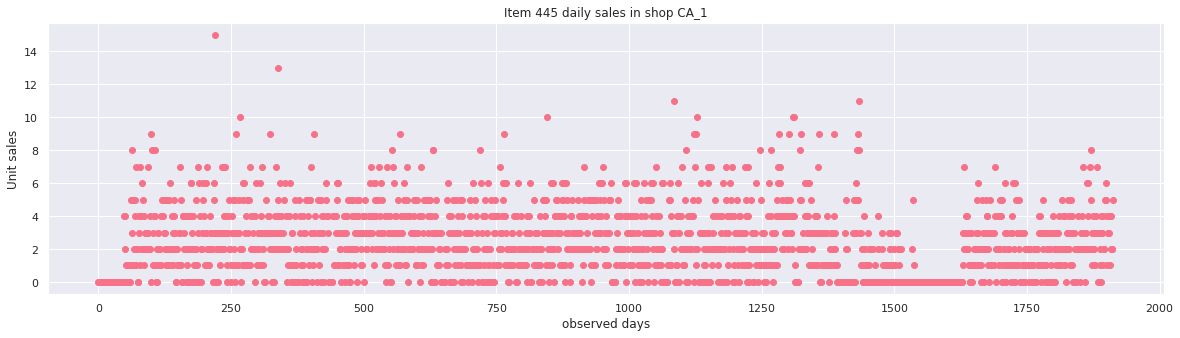

In [21]:
plt.figure(figsize=(20,5))
plt.plot(train[series_cols].iloc[idx].values, 'o')
plt.title("Item 445 daily sales in shop CA_1");
plt.xlabel("observed days")
plt.ylabel("Unit sales");

In [22]:
timeseries = train[series_cols].iloc[idx].values
h = 28

train_timeseries = timeseries[0:len(timeseries)-h]
dev_timeseries = timeseries[(len(timeseries)-h)::]

print(len(train_timeseries), len(dev_timeseries))

1885 28


In [23]:
naive_val = train_timeseries[-1]
naive_Q = np.ones(dev_timeseries.shape) * naive_val
naive_Q

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [24]:
spl(train_timeseries, dev_timeseries, naive_Q, 0.5)

0.8187879588064431

In [25]:
naive_val

0

In [26]:
residuals = train_timeseries - naive_val

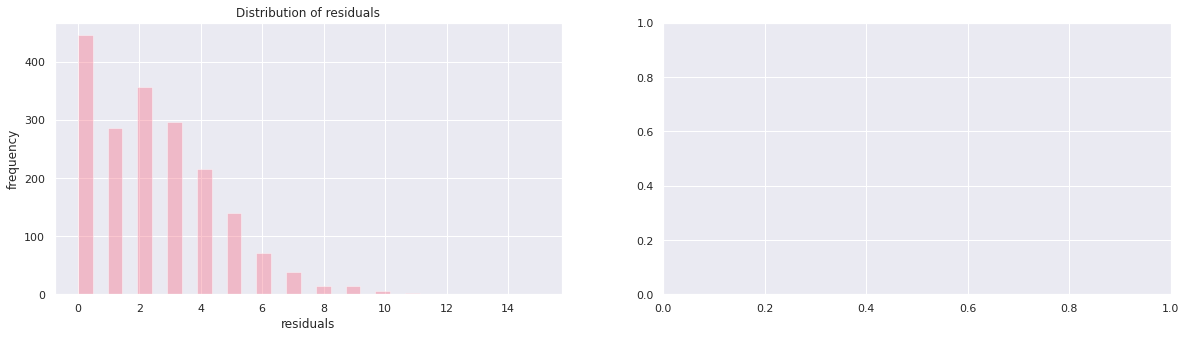

In [27]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(residuals, ax=ax[0], kde=False)
ax[0].set_xlabel("residuals")
ax[0].set_ylabel("frequency");
ax[0].set_title("Distribution of residuals");

In [28]:
np.mean(residuals)

2.3745358090185675

In [29]:
std_dev = np.std(residuals)
std_h = np.ones(dev_timeseries.shape)

for h in range(1, 29):
    std_h[h-1] = std_dev * np.sqrt(h)

In [30]:
std_h

array([ 2.09300689,  2.95995873,  3.62519427,  4.18601378,  4.68010568,
        5.1267989 ,  5.53757572,  5.91991746,  6.27902067,  6.61866893,
        6.94171853,  7.25038854,  7.54644366,  7.83131468,  8.10618082,
        8.37202755,  8.62968848,  8.87987618,  9.12320551,  9.36021136,
        9.5913625 ,  9.81707249, 10.03770841, 10.25359781, 10.46503444,
       10.67228297, 10.87558281, 11.07515144])

In [31]:
y_lower = np.ones(len(std_h))
y_upper = np.ones(len(std_h))
for h in range(len(std_h)):
    low_val = naive_Q[h] - 2.58 * std_h[h]
    if low_val < 0:
        y_lower[h] = 0
    else:
        y_lower[h] = low_val
    y_upper[h] = naive_Q[h] + 2.58 * std_h[h]

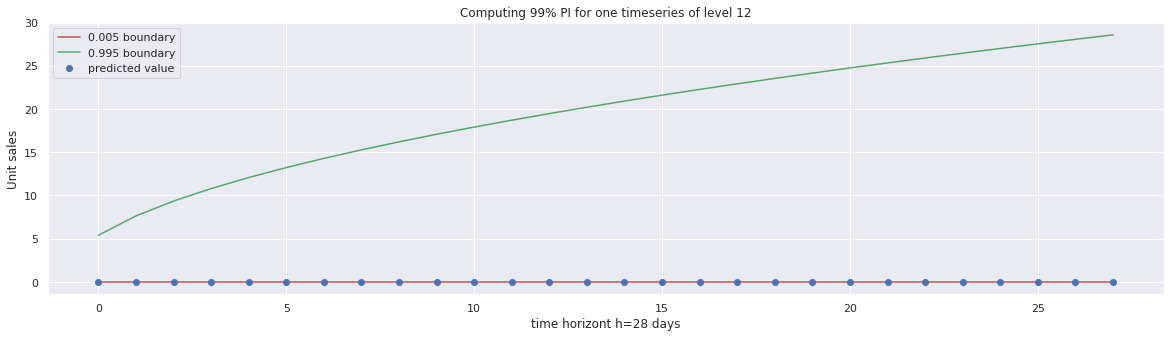

In [32]:
plt.figure(figsize=(20,5))
plt.plot(y_lower, c="r", label="0.005 boundary")
plt.plot(y_upper, c="g", label="0.995 boundary")
plt.plot(naive_Q, 'o', c="b", label="predicted value")
plt.title("Computing 99% PI for one timeseries of level 12");
plt.xlabel("time horizont h=28 days")
plt.ylabel("Unit sales");
plt.legend();

In [33]:
timeseries = train[series_cols].sum().values
len(timeseries)

1913

In [34]:
train_timeseries = timeseries[0:-28]
eval_timeseries = timeseries[-28::]
print(len(train_timeseries), len(eval_timeseries))
days = np.arange(1, len(series_cols)+1)

1885 28


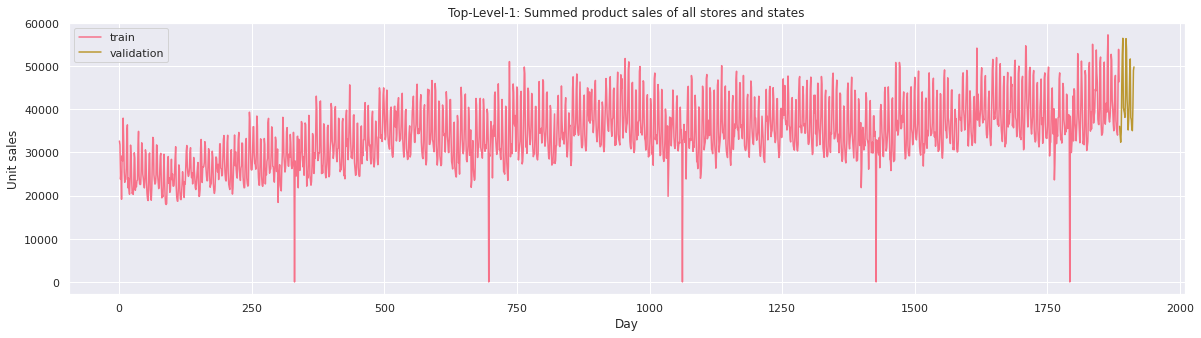

In [35]:
plt.figure(figsize=(20,5))
plt.plot(days[0:-28], train_timeseries, label="train")
plt.plot(days[-28::], eval_timeseries, label="validation")
plt.title("Top-Level-1: Summed product sales of all stores and states");
plt.legend()
plt.xlabel("Day")
plt.ylabel("Unit sales");

In [36]:
dates = calendar.iloc[0:len(timeseries)].date.values
df = pd.DataFrame(dates, columns=["ds"])
df.loc[:, "y"] = timeseries
df.head()

ds      y
0  2011-01-29  32631
1  2011-01-30  31749
2  2011-01-31  23783
3  2011-02-01  25412
4  2011-02-02  19146

In [37]:
train_df = df.iloc[0:-28]
train_df.shape

(1885, 2)

In [38]:
eval_df = df.iloc[-28::]
eval_df.shape

(28, 2)

In [39]:
uncertainty_interval_width = 0.25

In [40]:
m = Prophet(interval_width=uncertainty_interval_width)
m.fit(train_df)
future = m.make_future_dataframe(periods=28)
forecast = m.predict(future)
forecast.head()

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2011-01-29  23523.964684  29471.562624  31730.747068  23523.964684   
1 2011-01-30  23537.560789  29116.203421  31310.356169  23537.560789   
2 2011-01-31  23551.156893  21215.136806  23442.167238  23551.156893   
3 2011-02-01  23564.752998  18487.313506  20836.903588  23564.752998   
4 2011-02-02  23578.349102  18466.153621  20719.854925  23578.349102   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  23523.964684     6955.980646           6955.980646           6955.980646   
1  23537.560789     6591.871032           6591.871032           6591.871032   
2  23551.156893    -1497.238600          -1497.238600          -1497.238600   
3  23564.752998    -3909.698304          -3909.698304          -3909.698304   
4  23578.349102    -4157.959802          -4157.959802          -4157.959802   

        weekly  weekly_lower  weekly_upper      yearly  yearly_lower  \
0  7191.739496   7191.739496   7191.739496 -235.758850   -235.758850   
1  6738.973883   6738.973883   6738.973883 -147.102851   -147.102851   
2 -1441.086641  -1441.086641  -1441.086641  -56.151959    -56.151959   
3 -3946.718498  -3946.718498  -3946.718498   37.020194     37.020194   
4 -4290.146729  -4290.146729  -4290.146729  132.186927    132.186927   

   yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0   -235.758850                   0.0                         0.0   
1   -147.102851                   0.0                         0.0   
2    -56.151959                   0.0                         0.0   
3     37.020194                   0.0                         0.0   
4    132.186927                   0.0                         0.0   

   multiplicative_terms_upper          yhat  
0                         0.0  30479.945330  
1                         0.0  30129.431820  
2                         0.0  22053.918293  
3                         0.0  19655.054694  
4                         0.0  19420.389300

In [41]:
col_int = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
forecast[col_int].head()

ds          yhat    yhat_lower    yhat_upper
0 2011-01-29  30479.945330  29471.562624  31730.747068
1 2011-01-30  30129.431820  29116.203421  31310.356169
2 2011-01-31  22053.918293  21215.136806  23442.167238
3 2011-02-01  19655.054694  18487.313506  20836.903588
4 2011-02-02  19420.389300  18466.153621  20719.854925

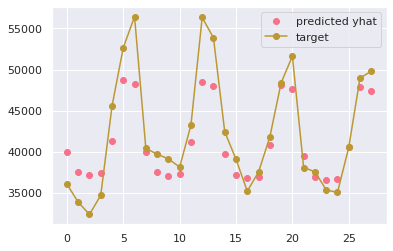

In [42]:
plt.plot(forecast.iloc[-28::].yhat.values, 'o', label="predicted yhat")
plt.plot(eval_df.y.values, 'o-', label="target")
plt.legend();

In [43]:
fig = plot_plotly(m, forecast)  
py.iplot(fig)

In [44]:
uncertainty_interval_width = 0.25

In [45]:
f_cols = [col for col in submission.columns if "F" in col]

In [46]:
submission_val = submission[submission.id.str.contains("validation")].copy()

In [47]:
def plugin_total_predictions():
    
    for uncertainty_interval_width in [0.005, 0.025, 0.165, 0.25]:
        upper = 1-uncertainty_interval_width
        lower = uncertainty_interval_width
    
        m = Prophet(interval_width=uncertainty_interval_width)
        m.fit(df)
        future = m.make_future_dataframe(periods=28)
        forecast = m.predict(future)
    
        submission_val.loc[
            (submission_val.id.str.contains("Total")) & (submission_val.id.str.contains(str(lower))),f_cols
        ] = np.round(forecast.yhat_lower.values[-28::])
    
        submission_val.loc[
            (submission_val.id.str.contains("Total")) & (submission_val.id.str.contains(str(upper))),f_cols
        ] = np.round(forecast.yhat_upper.values[-28::])
    
    submission_val.loc[
        (submission_val.id.str.contains("Total")) & (submission_val.id.str.contains(str(0.5))),f_cols
    ] = forecast.yhat.values[-28::]
    
    return submission_val

In [48]:
submission_val = plugin_total_predictions()
submission_val.loc[submission_val.id.str.contains("Total")]

Empty DataFrame
Columns: [id, F1, F2, F3, F4, F5, F6, F7, F8, F9, F10, F11, F12, F13, F14, F15, F16, F17, F18, F19, F20, F21, F22, F23, F24, F25, F26, F27, F28]
Index: []

[0 rows x 29 columns]

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [51]:
class MyLSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, batch_size, num_layers=1, output_dim=1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size=self.input_dim,
                            hidden_size=self.hidden_dim,
                            num_layers=self.num_layers,
                            dropout = 0.25)
        self.linear = nn.Linear(self.hidden_dim, output_dim)
        
    def init_hidden(self):
        self.h_zero = torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(device)
        self.c_zero = torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(device)
    
    def forward(self, x):
        lstm_output, (h_n, c_n) = self.lstm(x.view(len(x), self.batch_size, -1),
                                           (self.h_zero, self.c_zero))
        last_time_step = lstm_output.view(self.batch_size, len(x), self.hidden_dim)[-1]
        pred = self.linear(last_time_step)
        return pred
    

def train_model(model, data_dict, lr=1e-4, num_epochs=500):
    
    loss_fun = torch.nn.MSELoss(reduction="mean")
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses = np.zeros(num_epochs)
    phases = ["train", "eval"]
    losses_dict = {"train": [], "eval": []}
    predictions_dict = {"train": [], "eval": [] }
    
    for n in range(num_epochs):
        
        for phase in phases:
            
            x = data_dict[phase]["input"].to(device, dtype=torch.float)
            y = data_dict[phase]["target"].to(device, dtype=torch.float)
            
            if phase == "train":
                model.train()
            else:
                model.eval()
        
            optimiser.zero_grad()
            
            model.init_hidden()
            y_pred = model(x)
            
            if n == (num_epochs-1):
                predictions_dict[phase] = y_pred.float().cpu().detach().numpy()
            
            loss = loss_fun(y_pred.float(), y)
            losses_dict[phase].append(loss.item())
            
            if n % 50 == 0:
                print("{} loss: {}".format(phase, loss.item()))
            
            if phase == 'train':
                loss.backward()
                optimiser.step()
        
    return losses_dict, predictions_dict

def create_sequences(timeseries, seq_len):
    inputs = []
    targets = []
    
    max_steps = len(timeseries) - (seq_len+1)
    
    for t in range(max_steps):
        x = timeseries[t:(t+seq_len)]
        y = timeseries[t+seq_len]
        inputs.append(x)
        targets.append(y)
    
    return np.array(inputs), np.array(targets)

In [52]:
diff_series = np.diff(timeseries)
train_size = np.int(0.7 * len(diff_series))
train_diff_series = diff_series[0:train_size]
eval_diff_series = diff_series[train_size::]
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_train = scaler.fit_transform(train_diff_series.reshape(-1, 1))
scaled_eval = scaler.transform(eval_diff_series.reshape(-1,1))

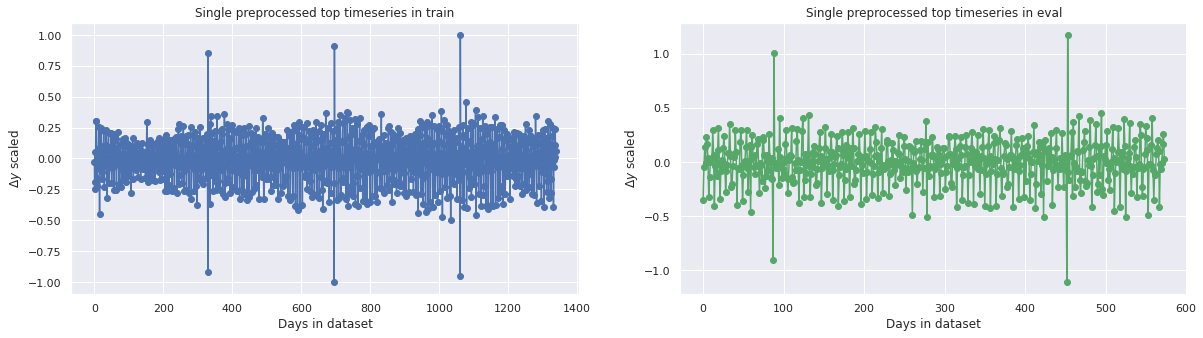

In [53]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(scaled_train, '-o', c="b")
ax[1].plot(scaled_eval, '-o', c="g")
ax[0].set_title("Single preprocessed top timeseries in train")
ax[1].set_title("Single preprocessed top timeseries in eval");
ax[0].set_xlabel("Days in dataset")
ax[1].set_xlabel("Days in dataset")
ax[0].set_ylabel("$\Delta y$ scaled")
ax[1].set_ylabel("$\Delta y$ scaled");

In [54]:
seq_len = 400
input_dim = 1
hidden_dim = 128
num_epochs = 600
lr=0.0005


x_train, y_train = create_sequences(scaled_train, seq_len)
x_eval, y_eval = create_sequences(scaled_eval, seq_len)

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_eval = torch.from_numpy(x_eval).float()
y_eval = torch.from_numpy(y_eval).float()

data_dict = {"train": {"input": x_train, "target": y_train},
             "eval": {"input": x_eval, "target": y_eval}}

In [55]:
model = MyLSTM(input_dim=input_dim,
               hidden_dim=hidden_dim,
               batch_size=seq_len)
model = model.to(device)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1



In [56]:
run_training = True
if run_training:
    losses_dict, predictions_dict = train_model(model, data_dict, num_epochs=num_epochs, lr=lr)

train loss: 0.03443581238389015
eval loss: 0.05671722814440727
train loss: 0.030265523120760918
eval loss: 0.05236203223466873
train loss: 0.018043873831629753
eval loss: 0.0396602600812912
train loss: 0.017106428742408752
eval loss: 0.0376754105091095
train loss: 0.015946004539728165
eval loss: 0.03513147309422493
train loss: 0.012415564619004726
eval loss: 0.027685269713401794
train loss: 0.011363891884684563
eval loss: 0.025438005104660988
train loss: 0.011299186386168003
eval loss: 0.02499150112271309
train loss: 0.011240593157708645
eval loss: 0.02462116628885269
train loss: 0.011185300536453724
eval loss: 0.02424958162009716
train loss: 0.011132943443953991
eval loss: 0.02388753369450569
train loss: 0.01108233630657196
eval loss: 0.023539336398243904


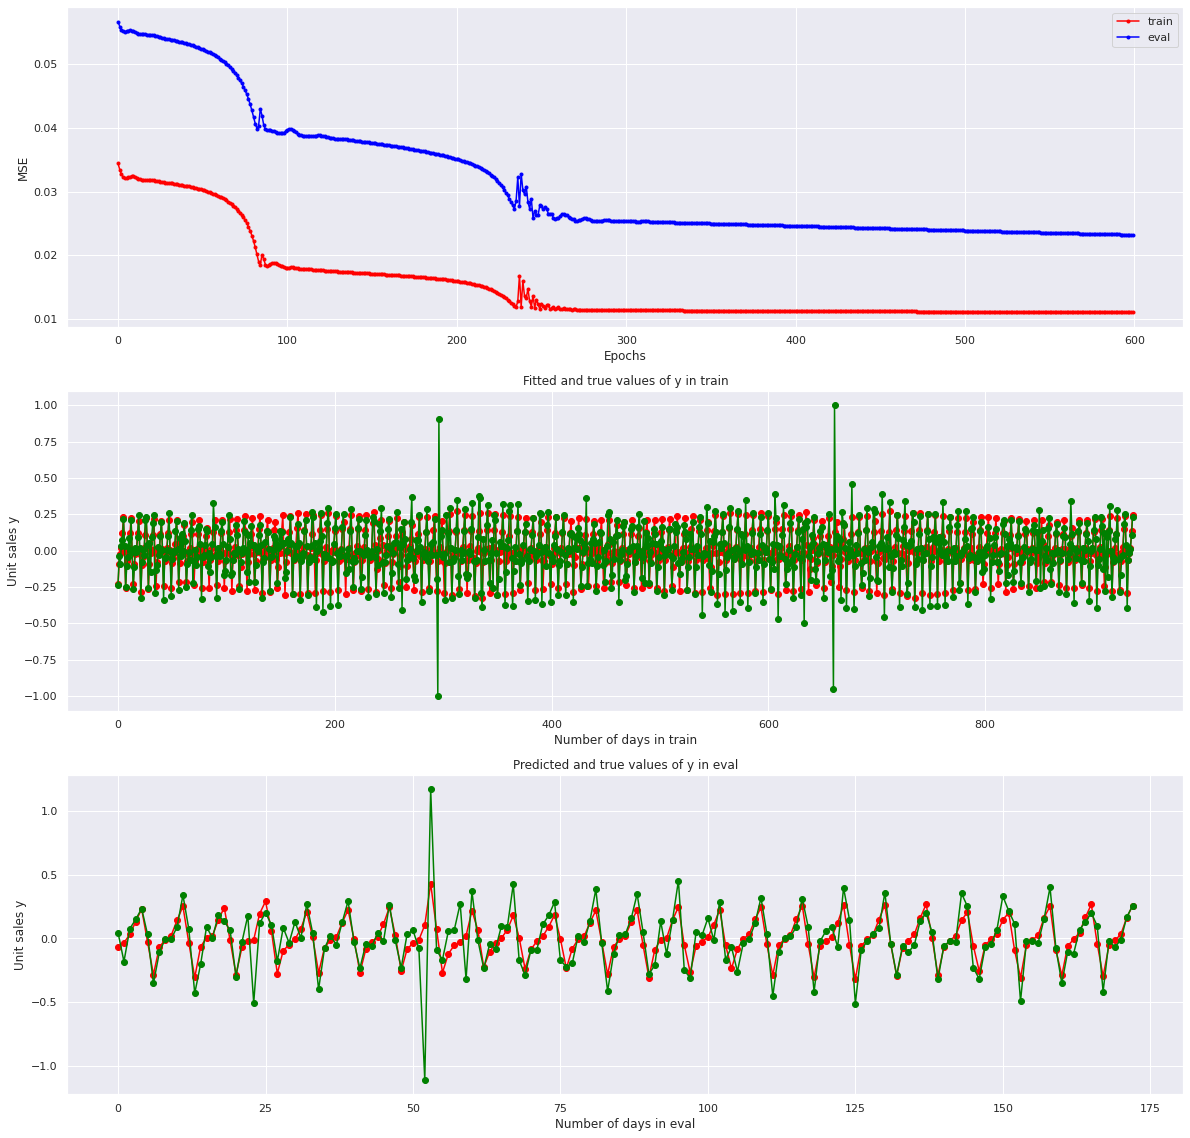

In [57]:
if run_training:
    
    fig, ax = plt.subplots(3,1,figsize=(20,20))
    ax[0].plot(losses_dict["train"], '.-', label="train", c="red")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("MSE")
    ax[0].plot(losses_dict["eval"], '.-', label="eval", c="blue");
    ax[0].legend();

    ax[1].plot(predictions_dict["train"], '-o', c="red")
    ax[1].plot(y_train, '-o', c="green")
    ax[1].set_title("Fitted and true values of y in train");
    ax[1].set_ylabel("Unit sales y");
    ax[1].set_xlabel("Number of days in train");

    ax[2].plot(predictions_dict["eval"], '-o', c="red")
    ax[2].plot(y_eval, '-o', c="green")
    ax[2].set_title("Predicted and true values of y in eval");
    ax[2].set_xlabel("Number of days in eval");
    ax[2].set_ylabel("Unit sales y");

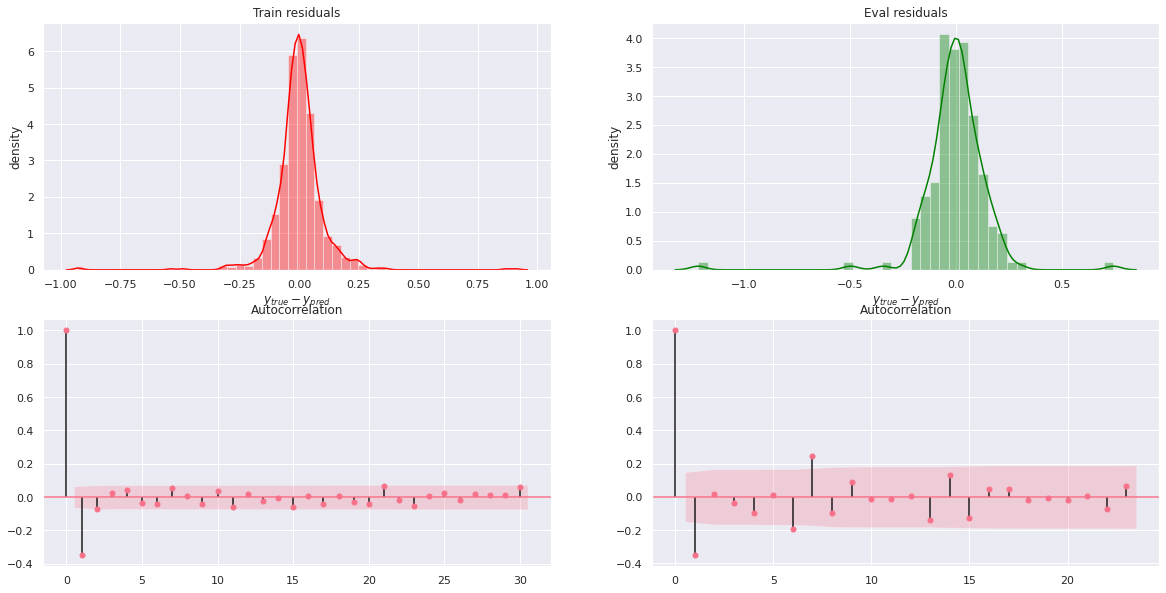

In [58]:
from statsmodels.graphics.tsaplots import plot_acf

if run_training:
    
    train_residuals = y_train-predictions_dict["train"]
    eval_residuals = y_eval-predictions_dict["eval"]
    
    fig, ax = plt.subplots(2,2,figsize=(20,10))
    sns.distplot(train_residuals, ax=ax[0,0], color="red")
    sns.distplot(eval_residuals, ax=ax[0,1], color="green")
    ax[0,0].set_title("Train residuals")
    ax[0,1].set_title("Eval residuals")
    ax[0,0].set_xlabel("$y_{true} - y_{pred}$")
    ax[0,1].set_xlabel("$y_{true} - y_{pred}$")
    ax[0,0].set_ylabel("density")
    ax[0,1].set_ylabel("density")
    
    plot_acf(train_residuals, ax=ax[1,0])
    plot_acf(eval_residuals, ax=ax[1,1])


In [59]:
sampled_residuals = np.random.choice(train_residuals[:, 0], size=len(y_train), replace=True)
sampled_residuals = sampled_residuals.reshape(-1,1)
new_response = predictions_dict["train"] + sampled_residuals

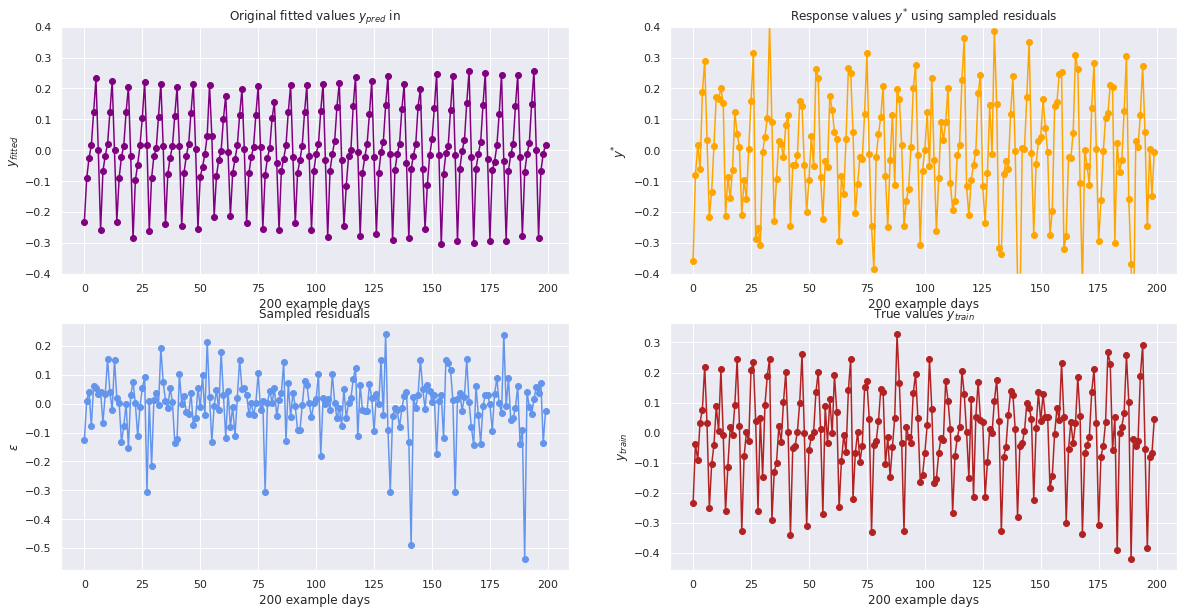

In [60]:
fig, ax = plt.subplots(2,2,figsize=(20,10))
ax[0,0].plot(predictions_dict["train"][0:200], 'o-', color="purple")
ax[0,0].set_title("Original fitted values $y_{pred}$ in ")
ax[0,0].set_xlabel("200 example days")
ax[0,0].set_ylim(-0.4, 0.4)
ax[0,0].set_ylabel("$y_{fitted}$")

ax[0,1].plot(new_response[0:200,0], 'o-', color="orange")
ax[0,1].set_title("Response values $y^{*}$ using sampled residuals");
ax[0,1].set_xlabel("200 example days")
ax[0,1].set_ylabel("$y^{*}$");
ax[0,1].set_ylim(-0.4, 0.4)

ax[1,0].plot(sampled_residuals[0:200], 'o-', color="cornflowerblue")
ax[1,0].set_title("Sampled residuals")
ax[1,0].set_xlabel("200 example days")
ax[1,0].set_ylabel("$\epsilon$")

ax[1,1].plot(y_train[0:200], 'o-', color="firebrick")
ax[1,1].set_title("True values $y_{train}$")
ax[1,1].set_xlabel("200 example days")
ax[1,1].set_ylabel("$y_{train}$");

In [61]:
responses = []
for n in range(100):
    # sample residuals using the historical residuals found in train
    sampled_residuals = np.random.choice(train_residuals[:, 0], size=len(y_eval), replace=True)
    sampled_residuals = sampled_residuals.reshape(-1,1)
    # create a synthetic future timeseries of eval by adding sampled residuals
    new_response = predictions_dict["eval"] + sampled_residuals
    # reverse the scaling
    new_response = scaler.inverse_transform(new_response)
    # concat the first value of the evaluation series and the response series
    new_response = np.hstack((timeseries[train_size], new_response[:,0]))
    # reverse the differnciation (trend removal) using cumsum
    new_response = np.cumsum(new_response)
    # save the future timeseries
    responses.append(new_response)
    
responses = np.array(responses)
responses.shape

(100, 174)

In [62]:
y_eval.shape

torch.Size([173, 1])

In [63]:
median_series = np.median(responses, axis=0)
eval_series = scaler.inverse_transform(y_eval)
eval_series = np.cumsum(np.hstack((timeseries[train_size-1], eval_series[:,0])))
low_q = 0.25
up_q = 0.75